In [ ]:
#adding google drive
from google.colab import drive
drive.mount("/content/drive/")
drive_path="/content/drive/MyDrive"



Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
pip install segmentation-models-pytorch


UNET




In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv,self).__init__()
    self.conv=nn.Sequential(
        nn.Conv2d(in_channels,out_channels, 3,1,1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels,out_channels, 3,1,1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )
  def forward (self,x):
    return self.conv(x)

class UNET(nn.Module):
    def __init__(
        self, in_channels=3, out_channels=1, features=[64,128,256,512],
    ):
      super(UNET,self).__init__()
      self.ups = nn.ModuleList()
      self.downs = nn.ModuleList()
      self.pool=nn.MaxPool2d(kernel_size=2, stride=2)

      # down part
      for feature in features:
        self.downs.append(DoubleConv(in_channels,feature))
        in_channels = feature

      # up part
      for feature in reversed(features):
        self.ups.append(
            nn.ConvTranspose2d(
                feature*2,feature, kernel_size=2, stride=2,
            )
        )
        self.ups.append(DoubleConv(feature*2, feature))

      self.bottleneck = DoubleConv(features[-1], features[-1]*2)
      self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self,x):
      skip_connections = []

      for down in self.downs:
        x=down(x)
        skip_connections.append(x)
        x=self.pool(x)

      x = self.bottleneck(x)
      skip_connections=skip_connections[::-1]

      for idx in range(0,len(self.ups),2):
        x=self.ups[idx](x)
        skip_connection=skip_connections[idx//2]

        if x.shape != skip_connection.shape:
          x = TF.resize(x,size=skip_connection.shape)

        concat_skip=torch.cat((skip_connection,x),dim=1)
        x=self.ups[idx+1](concat_skip)


      return self.final_conv(x)


def test():
  x=torch.randn((3,1,160,160))
  model = UNET(in_channels=1, out_channels=1)
  preds = model(x)
  print(preds.shape)
  print(x.shape)
  assert preds.shape == x.shape

if __name__=="__main__":
  test()


torch.Size([3, 1, 160, 160])
torch.Size([3, 1, 160, 160])


In [ ]:
#dataset
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

class CarvanaDataset(Dataset):
  def __init__(self,image_dir, mask_dir, transform=None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.images = os.listdir(image_dir)

  def __len__(self):
      return len(self.images)

  def __getitem__(self,index):
      img_path = os.path.join(self.image_dir, self.images[index])
      mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg","_mask.gif"))
      image = np.array(Image.open(img_path).convert("RGB"))
      mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
      # 0.0, 255.0
      mask[mask==255.0] = 1.0

      if self.transform is not None:
        augmentations = self.transform(image=image, mask=mask)
        image = augmentations["image"]
        mask = augmentations["mask"]

      return image, mask


In [ ]:
#training
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from segmentation_models_pytorch.losses import DiceLoss
#from model import UNet

#from utils import (
 #   load_checkpoint, save_checkpoint,
  #  getloaders,
   # check_accuracy,
    #save_predictions_as_imgs,)

#hyperparameters
LEARNING_RATE = 1E-4
DEVICE = "cuda"# if torch,cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 3
NUM_WORKERS=2
IMAGE_HEIGHT=160 #1280
IMAGE_WIDTH=240 #1918
PIN_MEMORY=True
LOAD_MODEL=False
TRAIN_IMG_DIR="/content/drive/MyDrive/dataset/train_images"
TRAIN_MASK_DIR="/content/drive/MyDrive/dataset/train_mask"
VAL_IMG_DIR="/content/drive/MyDrive/dataset/val_images"
VAL_MASK_DIR="/content/drive/MyDrive/dataset/val_masks"

def train_fn(loader,model,optimizer,loss_fn,scaler):
  loop = tqdm(loader)

  for batch_idx, (data, targets) in enumerate(loop):
      data = data.to(device=DEVICE)
      targets = targets.float().unsqueeze(1).to(device=DEVICE)

      #forward
      with torch.cuda.amp.autocast(enabled=True):
        # predictions = torch.sigmoid(model(data))
        predictions = STDsoftmax(model(data))
        loss=loss_fn(predictions,targets)

      #backward
      optimizer.zero_grad()
      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()

      #update tqdmloop
      loop.set_postfix(loss=loss.item())


def main():
  train_transform = A.Compose(
      [
          A.Resize(height=IMAGE_HEIGHT,width=IMAGE_WIDTH),
          A.Rotate(limit=35, p=1),
          A.HorizontalFlip(p=0.5),
          A.VerticalFlip(p=0.1),
          A.Normalize(
              mean=[0.0,0.0,0.0],
              std=[1.0,1.0,1.0],
              max_pixel_value=255.0,
          ),
          ToTensorV2()
      ],
  )

  val_transforms = A.Compose(
      [
          A.Resize(height=IMAGE_HEIGHT,width=IMAGE_WIDTH),
          A.Normalize(
              mean=[0.0,0.0,0.0],
              std=[1.0,1.0,1.0],
              max_pixel_value=255.0,
          ),
          ToTensorV2(),
      ],
  )

  model =UNET(in_channels=3, out_channels=1).to(DEVICE)
  #loss_fn = nn.BCEWithLogitsLoss() #change to for std softmax
  loss_fn = DiceLoss(mode='binary')


  optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


  train_loader, val_loader = get_loaders(
      TRAIN_IMG_DIR,
      TRAIN_MASK_DIR,
      VAL_IMG_DIR,
      VAL_MASK_DIR,
      BATCH_SIZE,
      train_transform,
      val_transforms,
      NUM_WORKERS,
      PIN_MEMORY,)

  scaler = torch.cuda.amp.GradScaler(enabled=True)
  for epoch in range(NUM_EPOCHS):
    train_fn(train_loader,model,optimizer, loss_fn, scaler)

    checkpoint ={"state_dict": model.state_dict(),
                 "optimizer":optimizer.state_dict(),
                 }
    save_checkpoint(checkpoint)

    check_accuracy(val_loader, model, device= DEVICE)
    save_predictions_as_imgs(
        val_loader, model, folder= "/content/drive/MyDrive/saved_images/", device= DEVICE
    )



if __name__ =="__main__":
  main()


<ipython-input-32-1aeec6826bd5>:105: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=True)
  0%|          | 0/64 [00:00<?, ?it/s]<ipython-input-32-1aeec6826bd5>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
100%|██████████| 64/64 [00:51<00:00,  1.25it/s, loss=0.607]


=> Saving checkpoint
Got  1785808/1843200 with acc 96.89
Dice score: 0.9256641864776611


100%|██████████| 64/64 [00:43<00:00,  1.48it/s, loss=0.61]


=> Saving checkpoint
Got  1714238/1843200 with acc 93.00
Dice score: 0.8472360372543335


100%|██████████| 64/64 [00:41<00:00,  1.54it/s, loss=0.632]


=> Saving checkpoint
Got  1792610/1843200 with acc 97.26
Dice score: 0.9338880777359009


In [ ]:
#utils
import torch
import torchvision
#from dataset import CarvanaDataset
from torch.utils.data import DataLoader

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
  print("=> Saving checkpoint")
  torch.save(state,filename)

def load_checkpoint(checkpoint,model):
  print("=> Loading checkpoint")
  model.load_state_dict(checkpoint["state_dict"])

def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transfrom,
    num_workers=4,
    pin_memory=True,
):
  train_ds= CarvanaDataset(
      image_dir=train_dir,
      mask_dir=train_maskdir,
      transform=train_transform,
  )

  train_loader = DataLoader(
      train_ds,
      batch_size=batch_size,
      num_workers=num_workers,
      pin_memory=pin_memory,
      shuffle=True,
  )
  val_ds = CarvanaDataset(
      image_dir=val_dir,
      mask_dir=val_maskdir,
      transform=val_transfrom,
      )
  val_loader = DataLoader(
      val_ds,
      batch_size=batch_size,
      num_workers=num_workers,
      pin_memory=pin_memory,
      shuffle=False,
  )

  return train_loader, val_loader
def check_accuracy(loader, model, device="cuda"):
  num_correct = 0
  num_pixels=0
  dice_score=0
  model.eval()

  with torch.no_grad():
    for x,y in loader:
      x=x.to(device)
      y=y.to(device).unsqueeze(1)
      # preds = torch.sigmoid(model(x))
      preds = STDsoftmax(model(x))
      preds=(preds>0.5).float()
      num_correct+=(preds==y).sum()
      num_pixels+=torch.numel(preds)
      dice_score += (2*(preds*y).sum())/((preds+y).sum()+1e-8)
  print(f"Got  {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}")
  print(f"Dice score: {dice_score/len(loader)}")
  model.train()

def save_predictions_as_imgs(
    loader, model, folder="/content/drive/MyDrive/saved_images/", device="cuda"
):
    model.eval()
    for idx, (x,y) in enumerate(loader):
      x=x.to(device=device)
      with torch.no_grad():
        # preds = torch.sigmoid(model(x))
        preds = STDsoftmax(model(x))
        preds = (preds>0.5).float()
      torchvision.utils.save_image(
          preds, f"{folder}/pred_{idx}.png"
      )
      #torchvision.utils.save_image(y.unsqueeze(1), f"{folder}")

    model.train()



New activation function soft threshold dynamics

In [ ]:
# Use: replace torch.sigmoid() with STDsoftmax()
import torch
import numpy as np
import torch.nn.functional as F

# Softmax function: converts input features into probability distribution
  # Probability values all between 0 and 1
  # Sum of all probabiltites is equal to 1
def softmax(o):
    return torch.exp(o)/torch.sum(torch.exp(o), dim=1,keepdim=True)
    # dim=1: sum across specified dimension (cols for each row in tensor)
    # keepdim=True: output tensor has same dimension as input tensor

# Function to create a Gaussian kernel from HW (Dr. Guo)
  # Input the Kernel Size (size) and the Standard Deviation (sigma)
  # Outputs tensor compatible with pytorch
def gaussian_kernel(size, sigma):
    """Generate a Gaussian kernel."""
    x = np.linspace(-size//2, size//2, size)
    y = np.linspace(-size//2, size//2, size)
    x, y = np.meshgrid(x, y)
    kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    kernel = kernel / np.sum(kernel)
    # Convert np array to pytorch tensor
    return torch.tensor(kernel, dtype=torch.float32)

# Define new activation function: STDsoftmax
  # Following STD Softmax Algorithm 3.1
  # Input: feature o
  # Output: soft segmentation function u
def STDsoftmax(o):
  epsilon = 0.1 # smoothing parameter
  l = 0.75 # regularization parameter
  iterations = 10 # set fixed number of iteration

  # Initialize
  u = torch.sigmoid(o) # start with standard softmax function

  b,c,h,w = o.size() # o a tensor: batch, channels, height, and width shapes
  # want channels size for convolution operations

  # need u0 and kernel to define p0

  # Gaussian kernel (k)
  n = 7 # set size of kernel 7x7 in paper
  stdev = 5 # standard deviation 5 in paper
  k = gaussian_kernel(n,stdev).unsqueeze(0).unsqueeze(0)
  # adjust shape of kernel to be compatible with pytorch
    # add dimensions for channels: [n,n] --> [1,1,n,n]
    # expected shape: [out_channels, in_channels, height, width]
  k = k.expand(c,1,n,n).to(o.device) # depthwise convolution
    # repeat kernel across input channels
  p = l*F.conv2d(1-2*u,k, groups =c, padding = "same")
  # F.conv2d(input, weight,bias,stride,padding,dilation,groups) from torch.nn.functional

  # We will set fixed number of iterations, rather than checking convergence
  for i in range(iterations):
    # Solution of minimization problem using STD softmax
    u = torch.sigmoid((o-p)/epsilon) # update u
    # set e = 1, so that simplifies to: p^t = lambda k * (1-2u^t)
      # e is weighting function
      # k is Gaussian kernel
    p = l*F.conv2d(1 - 2*u,k, groups =c, padding = "same")

  return u

Sigmoid function

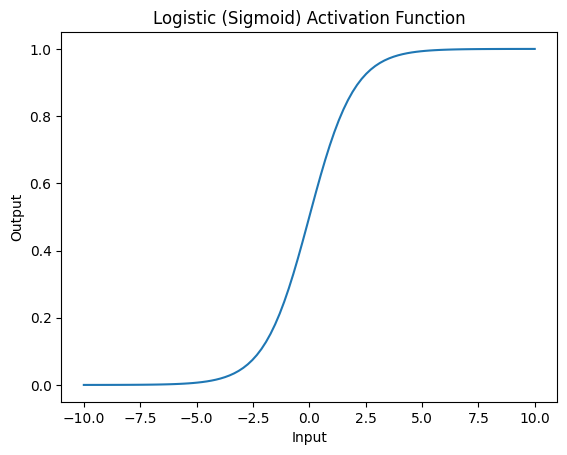

In [ ]:
# Plot of Standard Sigmoid Function
import torch
import matplotlib.pyplot as plt

# create a PyTorch tensor
x = torch.linspace(-10, 10, 100)

# apply the logistic activation function to the tensor
y = torch.sigmoid(x)

# plot the results
plt.plot(x.numpy(), y.numpy())
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Logistic (Sigmoid) Activation Function')
plt.show()
